# ESC-50: CNN 埋め込み（penultimate）を UMAP で可視化する

このノートブックは、学習済みモデル（`reports/<run_id>/best.pt` など）から **埋め込み（分類直前の特徴ベクトル）** を抽出し、UMAPで2次元に落として可視化します。

- **目的**: クラスの重なり、外れ値、誤分類の傾向を「地形」として見る  
- **方針**: 学習・評価CLIは変更せず、既存の `src/` を呼び出して探索する（研究の作法）

> 前提: `pip install -e .` により `import src...` が通る状態になっていること

In [1]:
from __future__ import annotations

from pathlib import Path
import os
import json
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

# 依存: umap-learn
import umap

print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())

c:\Users\hirok\venv\py312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch: 2.9.1+cu128
cuda available: True


## 1. プロジェクトルートを自動検出

VSCode/Jupyterはカレントディレクトリが揺れることがあるので、`config/default.yaml` を手掛かりにプロジェクトルートを推定します。

In [2]:
from pathlib import Path

def find_project_root(start: Path | None = None) -> Path:
    p = (start or Path.cwd()).resolve()
    for _ in range(10):
        if (p / "config" / "default.yaml").exists() and (p / "src").exists():
            return p
        if p.parent == p:
            break
        p = p.parent
    raise RuntimeError("Project root not found. Please run this notebook inside the project tree.")

ROOT = find_project_root()
ROOT

WindowsPath('C:/Users/hirok/code/02_sound/esc50_cnn')

## 2. 対象 run を選ぶ

- `RUN_ID` を直接指定するか、`latest_run()` で最新を自動選択します。

In [3]:
def latest_run(reports_dir: Path) -> Path:
    if not reports_dir.exists():
        raise FileNotFoundError(f"reports dir not found: {reports_dir}")
    candidates = [p for p in reports_dir.iterdir() if p.is_dir() and (p / "config_snapshot.yaml").exists()]
    if not candidates:
        raise FileNotFoundError("No run directories found under reports/.")
    return sorted(candidates, key=lambda p: p.name)[-1]

REPORTS_DIR = ROOT / "reports"
RUN_DIR = latest_run(REPORTS_DIR)      # ← 最新を使う
CHECKPOINT = "best"                   # "best" or "last"

print("RUN_DIR:", RUN_DIR)
print("Checkpoint:", CHECKPOINT)

RUN_DIR: C:\Users\hirok\code\02_sound\esc50_cnn\reports\20260105-175609
Checkpoint: best


## 3. config とモデルをロード

評価CLIと同じロジックで:

- `reports/<run_id>/config_snapshot.yaml` を読む
- `best.pt / last.pt` をロード

※ `src.eval.evaluate.load_model_from_checkpoint` は checkpoint 内に保存された `model_cfg` を使ってモデルを再構築します。

In [4]:
from src.utils.config import load_yaml
from src.eval.evaluate import load_model_from_checkpoint

cfg = load_yaml(RUN_DIR / "config_snapshot.yaml")

def pick_device(device_cfg: str) -> torch.device:
    if device_cfg == "cpu":
        return torch.device("cpu")
    if device_cfg == "cuda":
        return torch.device("cuda" if torch.cuda.is_available() else "cpu")
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

device = pick_device(cfg["project"]["device"])
device

device(type='cuda')

In [5]:
ckpt_path = RUN_DIR / f"{CHECKPOINT}.pt"
model, cfg_from_ckpt = load_model_from_checkpoint(ckpt_path, device)

model.eval()
print("Loaded checkpoint:", ckpt_path)
print("Model type:", type(model).__name__)

Loaded checkpoint: C:\Users\hirok\code\02_sound\esc50_cnn\reports\20260105-175609\best.pt
Model type: CNNClassifier


## 4. DataLoader を作る（全データ or testのみ）

UMAPは「全体の地形」を見るのに向いているので、ここでは **全2000サンプル** を対象にします。  
（test のみにしたい場合は `df_all` を `splits["test"]` に置き換えてください）

In [6]:
from torch.utils.data import DataLoader

from src.data.metadata import load_esc50_metadata
from src.data.split import SplitConfig, make_splits
from src.data.features import FeatureConfig, FeatureCache
from src.data.dataset import Esc50Dataset, AugmentConfig

# metadata
meta_csv = (ROOT / Path(cfg["paths"]["meta_csv"])).resolve()
df = load_esc50_metadata(meta_csv)
print("meta rows:", len(df), "num_classes:", df["target"].nunique())

# splits (fold-based by default)
s_cfg = cfg["split"]
split_cfg = SplitConfig(
    method=s_cfg["method"],
    train_folds=list(s_cfg.get("train_folds", [])),
    val_folds=list(s_cfg.get("val_folds", [])),
    test_folds=list(s_cfg.get("test_folds", [])),
    kfold_num_folds=int(s_cfg.get("kfold", {}).get("num_folds", 5)),
    kfold_test_fold=int(s_cfg.get("kfold", {}).get("test_fold", 1)),
    kfold_val_fold=int(s_cfg.get("kfold", {}).get("val_fold", 2)),
    random_seed=int(cfg["project"]["seed"]),
)
splits = make_splits(df, split_cfg)
print({k: len(v) for k, v in splits.items()})

# features + optional cache
f = cfg["features"]
a = cfg["audio"]
feat_cfg = FeatureConfig(
    sample_rate=int(a["sample_rate"]),
    duration_sec=float(a["duration_sec"]),
    n_fft=int(f["n_fft"]),
    hop_length=int(f["hop_length"]),
    win_length=int(f["win_length"]),
    n_mels=int(f["n_mels"]),
    f_min=float(f["f_min"]),
    f_max=None if f["f_max"] in (None, "null") else float(f["f_max"]),
    log_eps=float(f["log_eps"]),
    normalize=str(f["normalize"]),
)

cache = None
if bool(f["cache"]["enabled"]):
    cache = FeatureCache((ROOT / Path(cfg["paths"]["processed_dir"])).resolve(), feat_cfg)
    print("Feature cache:", cache.dir)
else:
    print("Feature cache: disabled")

# no augmentation in embedding extraction
aug_cfg = AugmentConfig(enabled=False, time_mask_param=0, freq_mask_param=0, gain_db=0.0, time_shift_pct=0.0)

audio_dir = (ROOT / Path(cfg["paths"]["audio_dir"])).resolve()

# Choose dataset scope:
df_all = df.copy()            # 全データ（おすすめ）
# df_all = splits["test"]     # testのみ

ds = Esc50Dataset(df_all, audio_dir, feat_cfg, cache, aug_cfg, is_train=False)

dl_cfg = cfg["dataloader"]
loader = DataLoader(
    ds,
    batch_size=int(dl_cfg["batch_size"]),
    shuffle=False,
    num_workers=int(dl_cfg["num_workers"]),
    pin_memory=bool(dl_cfg["pin_memory"]) and device.type == "cuda",
)

len(ds), next(iter(loader))[0].shape

meta rows: 2000 num_classes: 50
{'train': 1200, 'val': 400, 'test': 400}
Feature cache: C:\Users\hirok\code\02_sound\esc50_cnn\data\processed\features\15b3b6019f8d


(2000, torch.Size([32, 1, 128, 431]))

## 5. 埋め込み（penultimate features）を抽出する

このプロジェクトのCNNは `model.gap`（AdaptiveAvgPool2d）の出力が分類直前の特徴です。

- `gap` の出力: `[B, C, 1, 1]`
- 埋め込み: `flatten -> [B, C]`

ここでは **forward hook** を使って `gap` の出力を取り出します（学習コードには手を入れない）。

In [7]:
@torch.no_grad()
def extract_penultimate_embeddings(model: torch.nn.Module, loader: DataLoader, device: torch.device):
    model.eval().to(device)

    feats = []
    ys = []
    fns = []

    captured = {"x": None}

    def hook(_m, _inp, out):
        captured["x"] = out

    # CNNClassifier has model.gap
    if not hasattr(model, "gap"):
        raise AttributeError("Model has no attribute 'gap'. Adjust hook point for your model.")
    h = model.gap.register_forward_hook(hook)

    for x, y, fn in loader:
        x = x.to(device, non_blocking=True)
        _ = model(x)
        z = captured["x"]
        if z is None:
            raise RuntimeError("Hook did not capture features.")
        z = z.flatten(1).detach().cpu().numpy()  # [B,C]
        feats.append(z)
        ys.append(y.numpy())
        fns.append(np.array(fn))

    h.remove()

    X = np.concatenate(feats, axis=0)
    y = np.concatenate(ys, axis=0)
    filenames = np.concatenate(fns, axis=0)
    return X, y, filenames

X, y, filenames = extract_penultimate_embeddings(model, loader, device)
print("X:", X.shape, "y:", y.shape, "filenames:", filenames.shape)

X: (2000, 256) y: (2000,) filenames: (2000,)


## 6. UMAPで2次元に落とす

UMAPは局所構造を保ちながら2D化でき、クラスの重なり・分離が直感的に見えます。

- `n_neighbors`: 局所性の強さ（小さいほど局所クラスタ重視）
- `min_dist`: 2D上での詰まり具合（小さいほど凝集）

50クラスなので、まずは「色＝target id」で全体を見るのが定番です。

In [8]:
reducer = umap.UMAP(
    n_neighbors=30,
    min_dist=0.05,
    metric="euclidean",
    random_state=int(cfg["project"]["seed"]),
)
Z = reducer.fit_transform(X)
Z.shape

c:\Users\hirok\venv\py312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(2000, 2)

## 7. 可視化（全体）

- 点: 各サンプル
- 色: クラス（target id）

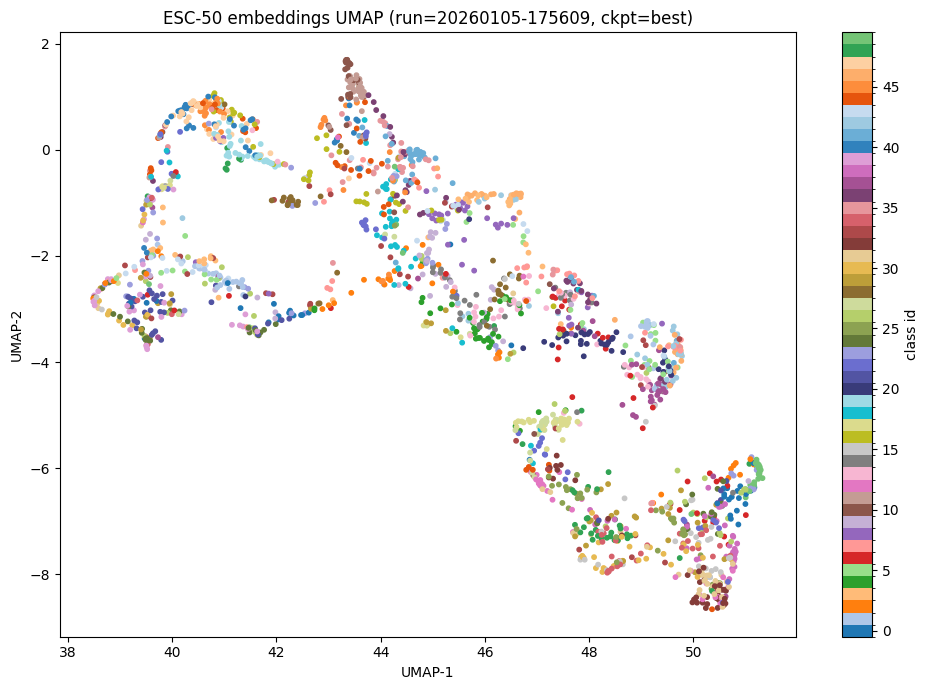

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# --- Discrete colormap with 50 distinct-ish colors ---
def make_discrete_cmap(n: int = 50):
    # tab20 系はカテゴリ可視化の定番（高コントラスト）
    base1 = plt.get_cmap("tab20").colors
    base2 = plt.get_cmap("tab20b").colors
    base3 = plt.get_cmap("tab20c").colors
    colors = list(base1) + list(base2) + list(base3)  # 60 colors
    colors = colors[:n]
    return mpl.colors.ListedColormap(colors, name=f"tab20x_{n}")

K = int(np.max(y)) + 1  # 50想定。念のため動的に
cmap = make_discrete_cmap(K)

# --- Discrete norm: map integer labels to discrete colors ---
boundaries = np.arange(-0.5, K + 0.5, 1.0)  # -0.5, 0.5, ..., K-0.5
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N)

fig, ax = plt.subplots(figsize=(10, 7))
sc = ax.scatter(Z[:, 0], Z[:, 1], c=y, s=10, cmap=cmap, norm=norm)

ax.set_title(f"ESC-50 embeddings UMAP (run={RUN_DIR.name}, ckpt={CHECKPOINT})")
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")

# --- Discrete colorbar ---
cbar = fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=ax,
    ticks=np.arange(0, K, 1),
    boundaries=boundaries,
    spacing="proportional",
)
cbar.set_label("class id")

# tickが多すぎるので、間引く（0,5,10,...）のが現実的
step = 5
cbar.set_ticks(np.arange(0, K, step))
cbar.set_ticklabels([str(i) for i in range(0, K, step)])

plt.tight_layout()
plt.show()

## 8. クラス名（category）を重ねて表示（重心ラベル）

50クラスの凡例は重いので、各クラスの重心に `category` 名を置きます。

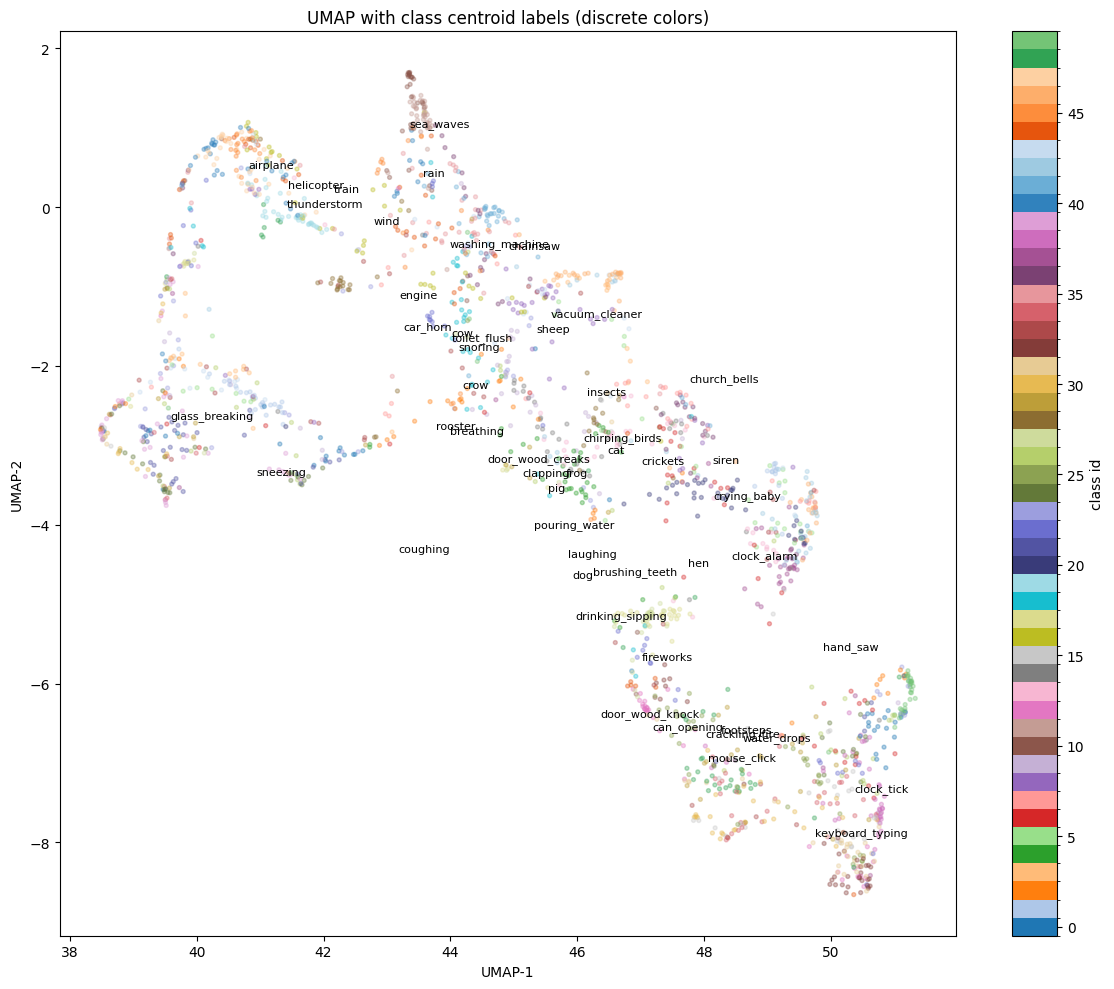

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# target -> category mapping
target_to_cat = df.sort_values("target").drop_duplicates("target").set_index("target")["category"].to_dict()

# --- Discrete colormap (same idea as before) ---
def make_discrete_cmap(n: int):
    base1 = plt.get_cmap("tab20").colors
    base2 = plt.get_cmap("tab20b").colors
    base3 = plt.get_cmap("tab20c").colors
    colors = list(base1) + list(base2) + list(base3)  # 60
    colors = colors[:n]
    return mpl.colors.ListedColormap(colors, name=f"tab20x_{n}")

K = int(np.max(y)) + 1  # usually 50
cmap = make_discrete_cmap(K)

boundaries = np.arange(-0.5, K + 0.5, 1.0)
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N)

# centroids in UMAP space
centroids = []
for t in sorted(np.unique(y)):
    mask = (y == t)
    centroids.append((int(t), Z[mask].mean(axis=0)))

fig, ax = plt.subplots(figsize=(12, 10))

sc = ax.scatter(
    Z[:, 0], Z[:, 1],
    c=y,
    s=8,
    alpha=0.35,
    cmap=cmap,
    norm=norm,
)

# centroid labels
for t, c in centroids:
    ax.text(c[0], c[1], target_to_cat.get(t, str(t)), fontsize=8)

ax.set_title("UMAP with class centroid labels (discrete colors)")
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")

# discrete colorbar
cbar = fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=ax,
    boundaries=boundaries,
    spacing="proportional",
)

# ticks are too many -> thin out
step = 5
cbar.set_ticks(np.arange(0, K, step))
cbar.set_ticklabels([str(i) for i in range(0, K, step)])
cbar.set_label("class id")

plt.tight_layout()
plt.show()

## 9. もし `inference_summary.csv` があるなら、誤分類をハイライト

`reports/<run_id>/inference_summary.csv` が存在する場合:

- 正解: 薄い点
- 誤り: 強調点（黒縁）

※「どのクラス同士が混ざるか」を見るのに便利です。

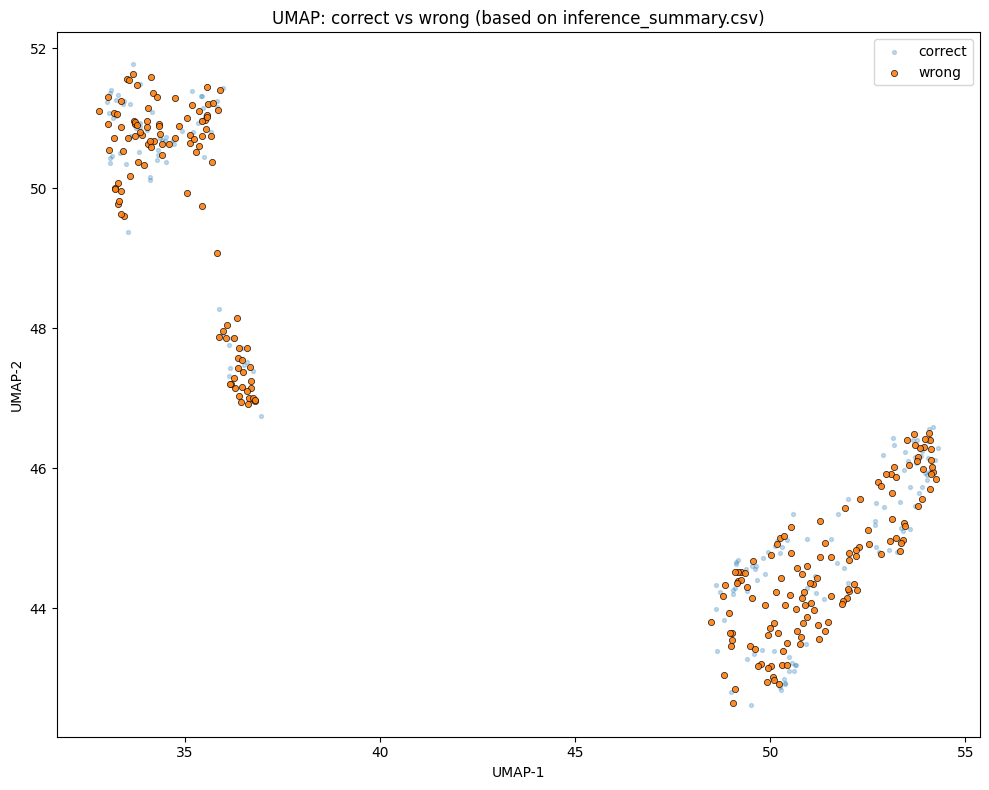

In [ ]:
summary_path = RUN_DIR / "inference_summary.csv"
if summary_path.exists():
    summary = pd.read_csv(summary_path)
    # expected columns: filename, y_true, y_pred, prob_*
    # our template uses 'y_true' and 'y_pred'
    if {"filename", "y_true", "y_pred"}.issubset(summary.columns):
        m = summary.set_index("filename")
        # align with current ordering
        y_true = m.loc[filenames, "y_true"].to_numpy()
        y_pred = m.loc[filenames, "y_pred"].to_numpy()
        correct = (y_true == y_pred)

        plt.figure(figsize=(10, 8))
        plt.scatter(Z[correct, 0], Z[correct, 1], s=8, alpha=0.25, label="correct")
        plt.scatter(Z[~correct, 0], Z[~correct, 1], s=20, alpha=0.9, label="wrong", edgecolors="k", linewidths=0.5)
        plt.title("UMAP: correct vs wrong (based on inference_summary.csv)")
        plt.xlabel("UMAP-1")
        plt.ylabel("UMAP-2")
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("inference_summary.csv exists but expected columns not found:", summary.columns.tolist())
else:
    print("No inference_summary.csv found at:", summary_path)

## 10. 出力を保存（再現性のため）

- `reports/<run_id>/tda/embeddings_umap.csv` : 2D座標 + ラベル + filename
- `reports/<run_id>/tda/embeddings_umap.npz` : X, y, filenames, Z を圧縮保存
- `reports/<run_id>/tda/umap.png` : 図を保存

探索結果を run と紐づけて保存するのが研究者っぽい運用です。

In [11]:
out_dir = RUN_DIR / "tda"
out_dir.mkdir(parents=True, exist_ok=True)

# dataframe
df_out = pd.DataFrame({
    "filename": filenames,
    "target": y.astype(int),
    "category": [target_to_cat.get(int(t), "") for t in y],
    "umap1": Z[:, 0],
    "umap2": Z[:, 1],
})
csv_path = out_dir / "embeddings_umap.csv"
df_out.to_csv(csv_path, index=False)

# npz
npz_path = out_dir / "embeddings_umap.npz"
np.savez_compressed(npz_path, X=X, y=y, filenames=filenames, Z=Z)

# plot
png_path = out_dir / "umap.png"
plt.figure(figsize=(10, 8))
plt.scatter(Z[:, 0], Z[:, 1], c=y, s=10, alpha=0.8)
plt.title(f"ESC-50 embeddings UMAP (run={RUN_DIR.name}, ckpt={CHECKPOINT})")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.savefig(png_path, dpi=200)
plt.close()

print("Wrote:", csv_path)
print("Wrote:", npz_path)
print("Wrote:", png_path)

Wrote: C:\Users\hirok\code\02_sound\esc50_cnn\reports\20260105-175609\tda\embeddings_umap.csv
Wrote: C:\Users\hirok\code\02_sound\esc50_cnn\reports\20260105-175609\tda\embeddings_umap.npz
Wrote: C:\Users\hirok\code\02_sound\esc50_cnn\reports\20260105-175609\tda\umap.png


## 11. （オプション）TDAの入口：埋め込み点群の Persistent Homology を試す

UMAPは可視化、PHは「スケールに頑健な形状特徴」を取る道具です。  
ただし **点数2000のPHは重い**ので、まずはランダムサブサンプル（例: 400点）で雰囲気を見るのが定石です。

> 依存: `pip install ripser persim`

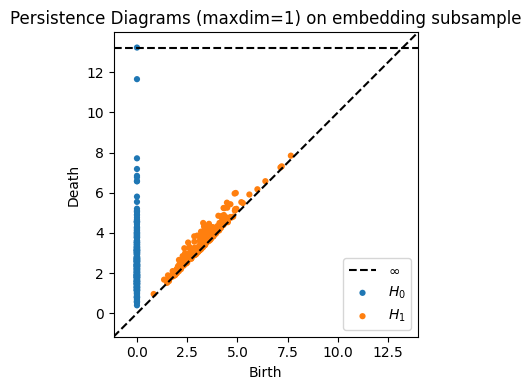

In [12]:
# Optional: run only if ripser/persim are installed
try:
    from ripser import ripser
    from persim import plot_diagrams

    rng = np.random.default_rng(int(cfg["project"]["seed"]))
    n_sub = min(400, X.shape[0])
    idx = rng.choice(X.shape[0], size=n_sub, replace=False)
    X_sub = X[idx]

    dgms = ripser(X_sub, maxdim=1)["dgms"]

    plt.figure(figsize=(6, 4))
    plot_diagrams(dgms, show=False)
    plt.title("Persistence Diagrams (maxdim=1) on embedding subsample")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("PH optional block skipped:", repr(e))